# Clustering and the K-means Algorithm

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Introduction

This notebook introduces [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) and one of the most common algorithms for it, [k-means](https://en.wikipedia.org/wiki/K-means_clustering).

It also introduces 

* Jupyter, which is a tool for creating notebooks like this that contain text, code, and results;

* NumPy, which we'll use to perform array operations;

* Pandas, which we'll use to read and clean the data file; and

* scikit-learn, which provides an implementation of k-means.

I will proceed "top-down"; that is, we'll use scikit-learn first, then we'll open the hood and see how it works.

But first, let me introduce myself.

### Bio

I am a professor at [Olin College](http://www.olin.edu/), which is a small engineering school near Boston, Massachusetts.

Olin was created in 1999 with the mission to transform engineering education.

In [1]:
%%html
<iframe src="https://www.google.com/maps/embed?pb=!1m14!1m8!1m3!1d1512.1750667940496!2d-71.26457056946273!3d42.29270982134376!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x0%3A0xa038229eeed8c35b!2sOlin%20College%20of%20Engineering!5e1!3m2!1sen!2sus!4v1594232142090!5m2!1sen!2sus" width="600" height="450" frameborder="0" style="border:0;" allowfullscreen="" aria-hidden="false" tabindex="0"></iframe>

I have been at Olin since 2003.  I teach classes related to software, data science, Bayesian statistics, and physical modeling.

I have written several books on these topics, including *Think Python* and *Think Stats*.  Most are published by O'Reilly Media, which is famous for putting animals on their covers:

<img src="https://greenteapress.com/covers/think_python_cover.jpeg">

But all of them are freely available from [Green Tea Press](https://greenteapress.com/wp/).

Finally, I write a blog about Data Science and related topics, called [Probably Overthinking It](https://www.allendowney.com/blog/).

## Jupyter and Colab

Jupyter is a tool for writing notebooks that contain text, code, and results.

You can install Jupyter on your own computer, but can also use services like Colab that run the notebook for you.
In that case, you don't have to install anything; you just need a browser.

A notebook contains:

* Text cells, which contain text in Markdown or HTML, and

* Code cell, which contain code in Python or one of about 100 other languages.

This is a text cell; the one below is a code cell.

In [2]:
print('Hello, Jupyter')

Hello, Jupyter


On Colab, code cells have a triangle "Play" icon on the left side.  You can press it to run the code in the cell.

If you select a cell by clicking on it, you can also run it by pressing Shift-Enter.

As an exercise:

1. Run the `print` statement in the previous cell.
2. Modify the code in that cell and run it again.
3. Run the next cell, which imports the Python modules we'll use later.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Also run the following cell, which defines a function we'll use.

In [4]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

## Clustering

Cluster analysis is a set of tools for looking at data and 

* Discovering groups, species, or categories,

* Defining boundaries between groups.

It is a form of "unsupervised" learning, which means that the only input is the dataset itself; the algorithm is not given any correct examples to learn from.

As an example, I'll used data collected and made available by Dr. Kristen Gorman at the Palmer Long-Term Ecological Research Station in Antarctica.

This dataset was published to support this article: Gorman, Williams, and Fraser, ["Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus *Pygoscelis*)"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081), March 2014.

The following cell downloads the raw data.

In [5]:
# Load the data files from https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

import os

if not os.path.exists('penguins_raw.csv'):
    !wget https://github.com/allisonhorst/palmerpenguins/raw/master/inst/extdata/penguins_raw.csv

The dataset is stored in a CSV file, which contains one row for each penguin and one column for each variable.

I'll use Pandas to read the CSV file and put the results in a `DataFrame`.

In [6]:
df = pd.read_csv('penguins_raw.csv')
df.shape

(344, 17)

A `DataFrame` is like a 2-D array, but it also contains names for the columns and labels for the rows.

The `shape` of the `DataFrame` is the number of rows and columns.

The `head` method displays the first few rows.

In [7]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


Three species of penguins are represented in the dataset: Adelie, Chinstrap and Gentoo, as shown in this illustration (by Allison Horst, available under the [CC-BY](https://creativecommons.org/licenses/by/2.0/) license):

<img width="400" src="https://pbs.twimg.com/media/EaAWkZ0U4AA1CQf?format=jpg&name=4096x4096">

In this dataset we are told that there are three species, and we are told which species each penguin belongs to.
But for purposes of clustering, we'll pretend we don't have this information, and we'll see whether the algorithm "discovers" the different species.

The measurements we'll use are:

* Body Mass in grams (g).

* Flipper Length in millimeters (mm).

* Culmen Length in millimeters.  

* Culmen Depth in millimeters.

If you are not familiar with the word "culmen", it refers to the [top margin of the beak](https://en.wikipedia.org/wiki/Bird_measurement#Culmen), as shown in the following illustration (also by Allison Horst):

<img width="400" src="https://pbs.twimg.com/media/EaAXQn8U4AAoKUj?format=jpg&name=4096x4096">

This might seem like an artificial exercise.  If we already know that there are three species, why are we trying to discover them?

For now, I'll just say that it's a learning example.  But let's come back to this question: what is unsupervised clustering good for?

## Distributions of measurements

The measurements we have will be most useful for clustering if there are substantial differences between species and small variation within species.  To see whether that is true, and to what degree, I will plot 

For convenience, I'll create a new column, called `Species2`, that contains a shorter version of the species names.

In [8]:
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

The following function takes the `DataFrame` and a column name, and returns a dictionary that maps from each species name to a `Cdf` of the values in the given column. 

In [9]:
grouped = df.groupby('Species2')
grouped

In [10]:
for name, group in grouped:
    print(name, len(group))

Adelie 152
Chinstrap 68
Gentoo 124


In [11]:
varname = 'Flipper Length (mm)'

for name, group in grouped:
    print(name, group[varname].mean())

Adelie 189.95364238410596
Chinstrap 195.8235294117647
Gentoo 217.1869918699187


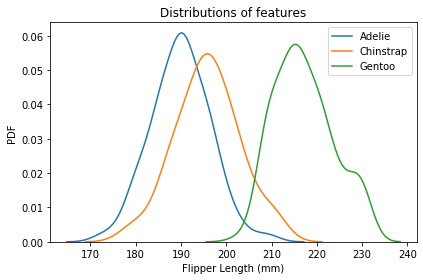

In [12]:
for name, group in grouped:
    sns.kdeplot(group[varname], label=name)
    
decorate(xlabel=varname,
         ylabel='PDF',
         title='Distributions of features')

In [13]:
def make_kdeplots(df, varname):
    """Make a KDE plot for each species.
    
    df: DataFrame
    varname: string column name
    by: string column name
    
    returns: dictionary from species name to Cdf
    """
    grouped = df.groupby('Species2')
    for name, group in grouped:
        sns.kdeplot(group[varname], label=name)
    
    decorate(xlabel=varname,
         ylabel='PDF',
         title='Distributions of features')

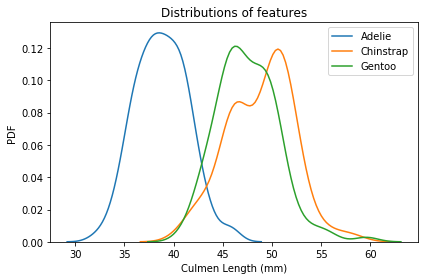

In [14]:
make_kdeplots(df, 'Culmen Length (mm)')

**Exercise:**

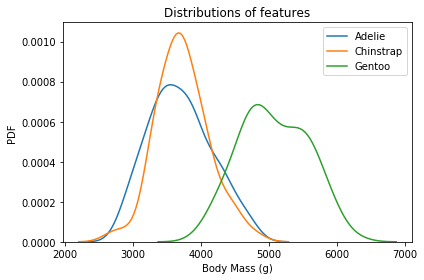

In [15]:
make_kdeplots(df, 'Body Mass (g)')

## Scatter plot

If we can identify Gentoo penguins by flipper length and Adelie penguins by culmen length, maybe we can combine these variables to identify all three species. 

I'll start by making a scatter plot of the data.

In [16]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
var3 = 'Culmen Depth (mm)'
var4 = 'Body Mass (g)'

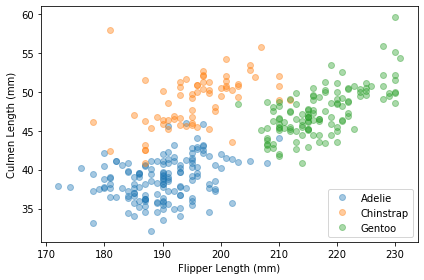

In [17]:
for name, group in grouped:
    plt.plot(group[var1], group[var2], 
             'o', alpha=0.4, label=name)
    
decorate(xlabel=var1, ylabel=var2)

Using those two features, we can divide the penguins into clusters with not much overlap.

We're going to make lots of scatter plots, so let's wrap that code in a function.

And we'll generalize it to take `by` as a parameter, so we can group by any column, not just `Species2`.

In [18]:
def scatterplot(df, var1, var2, by):
    """Make a scatter plot.
    
    df: DataFrame
    var1: string column name, x-axis
    var2: string column name, y-axis
    by: string column name, groupby
    """
    grouped = df.groupby(by)
    for name, group in grouped:
        plt.plot(group[var1], group[var2], 
                 'o', alpha=0.4, label=name)
    
    decorate(xlabel=var1, ylabel=var2)

Here's a scatter plot of flipper and culmen length for the three species.

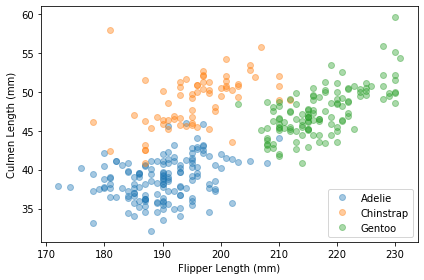

In [19]:
scatterplot(df, var1, var2, 'Species2')

Now, let's pretend we don't know anything about the different species, and we'll see whether we can rediscover these clusters.

To see what the problem looks like, I'll add a column of labels to the `DataFrame` and set it to 0 for all penguins.

In [20]:
df['labels'] = 0

Now if we group by label, there's only one big cluster.

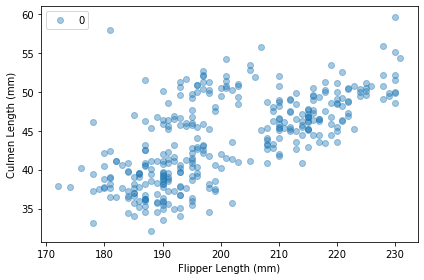

In [21]:
scatterplot(df, var1, var2, 'labels')

Let's see what happens if we run k-means clustering on this data.

## Clustering

In [22]:
df.shape

(344, 19)

In [23]:
features = [var1, var2]
data = df.dropna(subset=features).copy()
data.shape

(342, 19)

In [24]:
M = data[features].to_numpy()

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(M)

In [26]:
data['labels'] = kmeans.labels_
data['labels']

0      0
1      0
2      2
4      0
5      0
      ..
339    1
340    2
341    2
342    1
343    2
Name: labels, Length: 342, dtype: int32

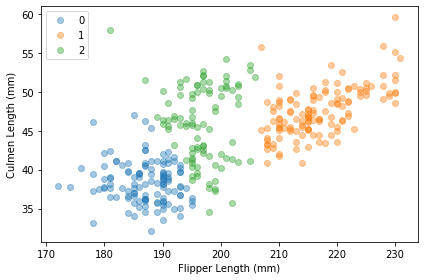

In [27]:
scatterplot(data, var1, var2, 'labels')

In [28]:
kmeans.cluster_centers_

array([[186.99166667,  38.4275    ],
       [216.88372093,  47.56744186],
       [196.7311828 ,  45.95483871]])

In [29]:
xs, ys = np.transpose(kmeans.cluster_centers_)

In [30]:
xs

array([186.99166667, 216.88372093, 196.7311828 ])

In [31]:
ys

array([38.4275    , 47.56744186, 45.95483871])

In [32]:
def plot_centers(centers, color='C3'):
    """Plot cluster centers.
    
    centers: array with x and y columns
    """
    xs, ys = np.transpose(centers)
    options = dict(color=color, ls='none', mfc='none')
    plt.plot(xs, ys, marker='o', ms=15, **options)
    plt.plot(xs, ys, marker='x', ms=10, **options)

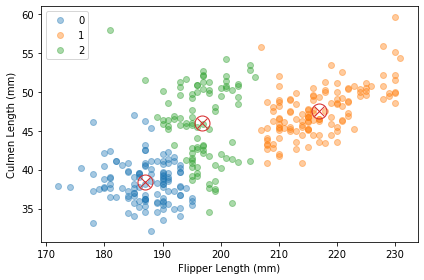

In [33]:
scatterplot(data, var1, var2, 'labels')
plot_centers(kmeans.cluster_centers_)

## Choose random starting clusters

In [34]:
index = np.random.choice(len(M), size=3)
index

array([223, 144, 119])

In [35]:
centers = np.array(M[index])
centers

array([[221. ,  48.2],
       [185. ,  39. ],
       [187. ,  36.2]])

In [98]:
def choose_random_start(M, k):
    """
    """
    index = np.random.choice(len(M), size=k)
    centers = M[index]
    return centers

In [99]:
centers = choose_random_start(M, 3)

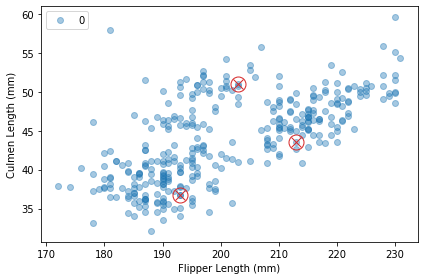

In [100]:
data['labels'] = 0
scatterplot(data, var1, var2, 'labels')
plot_centers(centers)

## Compute distances

As an example, I'll pick just one of the centers.

In [101]:
center_x, center_y = centers[0]
center_x, center_y

(193.0, 36.8)

In [102]:
x, y = np.transpose(M)
x.shape

(342,)

In [103]:
x.max()

231.0

In [104]:
y.max()

59.6

In [105]:
distances = np.hypot(x-center_x, y-center_y)
distances.shape

(342,)

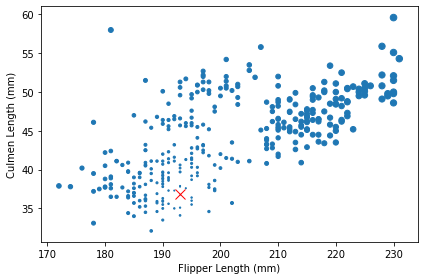

In [106]:
plt.plot(center_x, center_y, 'rx', markersize=10)
plt.scatter(x, y, s=distances)

decorate(xlabel=var1, ylabel=var2)

And let's make that a function:

In [107]:
def compute_distances(M, center):
    """
    """
    x, y = np.transpose(M)
    center_x, center_y = center
    distances = np.hypot(x-center_x, y-center_y)
    return distances

In [108]:
distance_arrays = [compute_distances(M, center)
                   for center in centers]

In [109]:
A = np.stack(distance_arrays)
A.shape

(3, 342)

In [110]:
data['labels'] = np.argmin(A, axis=0)
data['labels']

0      0
1      0
2      0
4      0
5      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: labels, Length: 342, dtype: int64

In [111]:
def compute_labels(M, centers):
    distance_arrays = [compute_distances(M, center)
                   for center in centers]
    A = np.stack(distance_arrays)
    labels = np.argmin(A, axis=0)
    return labels

In [112]:
data['labels'] = compute_labels(M, centers)

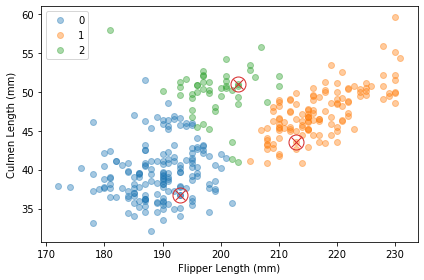

In [113]:
scatterplot(data, var1, var2, 'labels')
plot_centers(centers)

## Find new centers


In [114]:
grouped = data.groupby('labels')
for name, group in grouped:
    print(name, len(group))

0 168
1 126
2 48


In [115]:
data.groupby('labels')[features].mean()

,Flipper Length (mm),Culmen Length (mm)
labels,,
0,189.333333,39.602381
1,217.047619,47.380952
2,199.104167,49.960417


In [116]:
def compute_new_centers(data, features):
    means = data.groupby('labels')[features].mean()
    return means.to_numpy()

In [117]:
new_centers = compute_new_centers(data, features)
new_centers

array([[189.33333333,  39.60238095],
       [217.04761905,  47.38095238],
       [199.10416667,  49.96041667]])

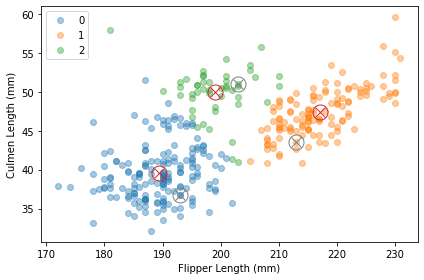

In [118]:
scatterplot(data, var1, var2, 'labels')
plot_centers(centers, color='gray')
plot_centers(new_centers, color='C3')

In [119]:
def k_means(data, features, k):
    """Cluster by k means.
    
    data: DataFrame
    features: list of string column names
    k: number of clusters
    
    returns: array of centers
    """
    M = data[features].to_numpy()
    centers = choose_random_start(M, k)

    for i in range(15):
        data['labels'] = compute_labels(M, centers)
        centers = compute_new_centers(data, features)

    return centers

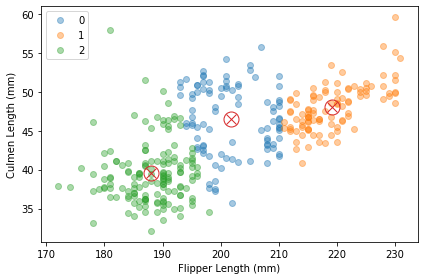

In [121]:
centers = k_means(data, features, 3)
scatterplot(data, var1, var2, 'labels')
plot_centers(centers, color='C3')

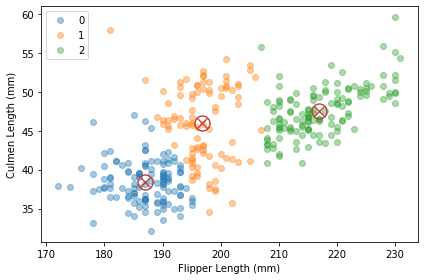

In [122]:
from time import sleep
from IPython.display import clear_output
interval = 1

centers = choose_random_start(M, k=3)
plt.figure()

for i in range(10):
    # label and scatter plot
    data['labels'] = compute_labels(M, centers)
    scatterplot(data, var1, var2, 'labels')
    plot_centers(centers, color='gray')
        
    # compute new centers and plot them
    new_centers = compute_new_centers(data, features)        
    plot_centers(new_centers)
    centers = new_centers
        
    # show the plot, wait, and clear
    plt.show()
    sleep(interval)        
    clear_output(wait=True)

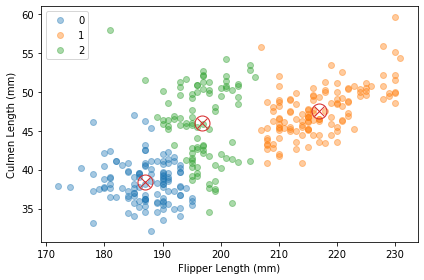

In [123]:
kmeans = KMeans(n_clusters=3).fit(M)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')
plot_centers(kmeans.cluster_centers_)

In [59]:
means = M.mean(axis=0)
means

array([200.91520468,  43.92192982])

In [60]:
stds = M.std(axis=0)

In [61]:
M_std = (M - means) / stds

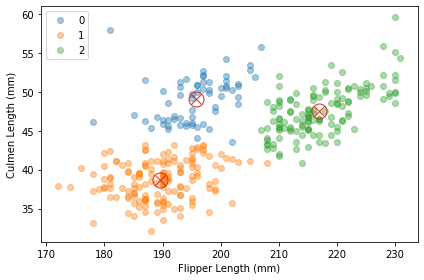

In [62]:
kmeans = KMeans(n_clusters=3).fit(M_std)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')

centers = kmeans.cluster_centers_ * stds + means
plot_centers(centers)

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(M)
M_std = scaler.transform(M)

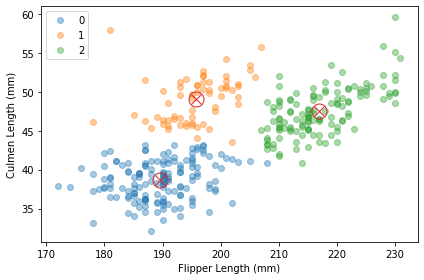

In [64]:
kmeans = KMeans(n_clusters=3).fit(M_std)
data['labels'] = kmeans.labels_

scatterplot(data, var1, var2, 'labels')

centers = scaler.inverse_transform(kmeans.cluster_centers_)
plot_centers(centers)

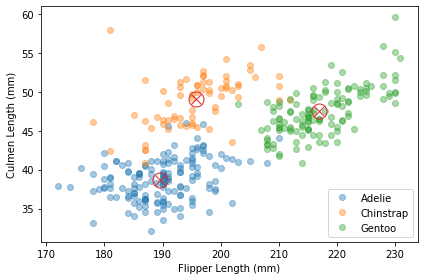

In [65]:
scatterplot(data, var1, var2, 'Species2')
plot_centers(centers)